Number of independent observations: 119


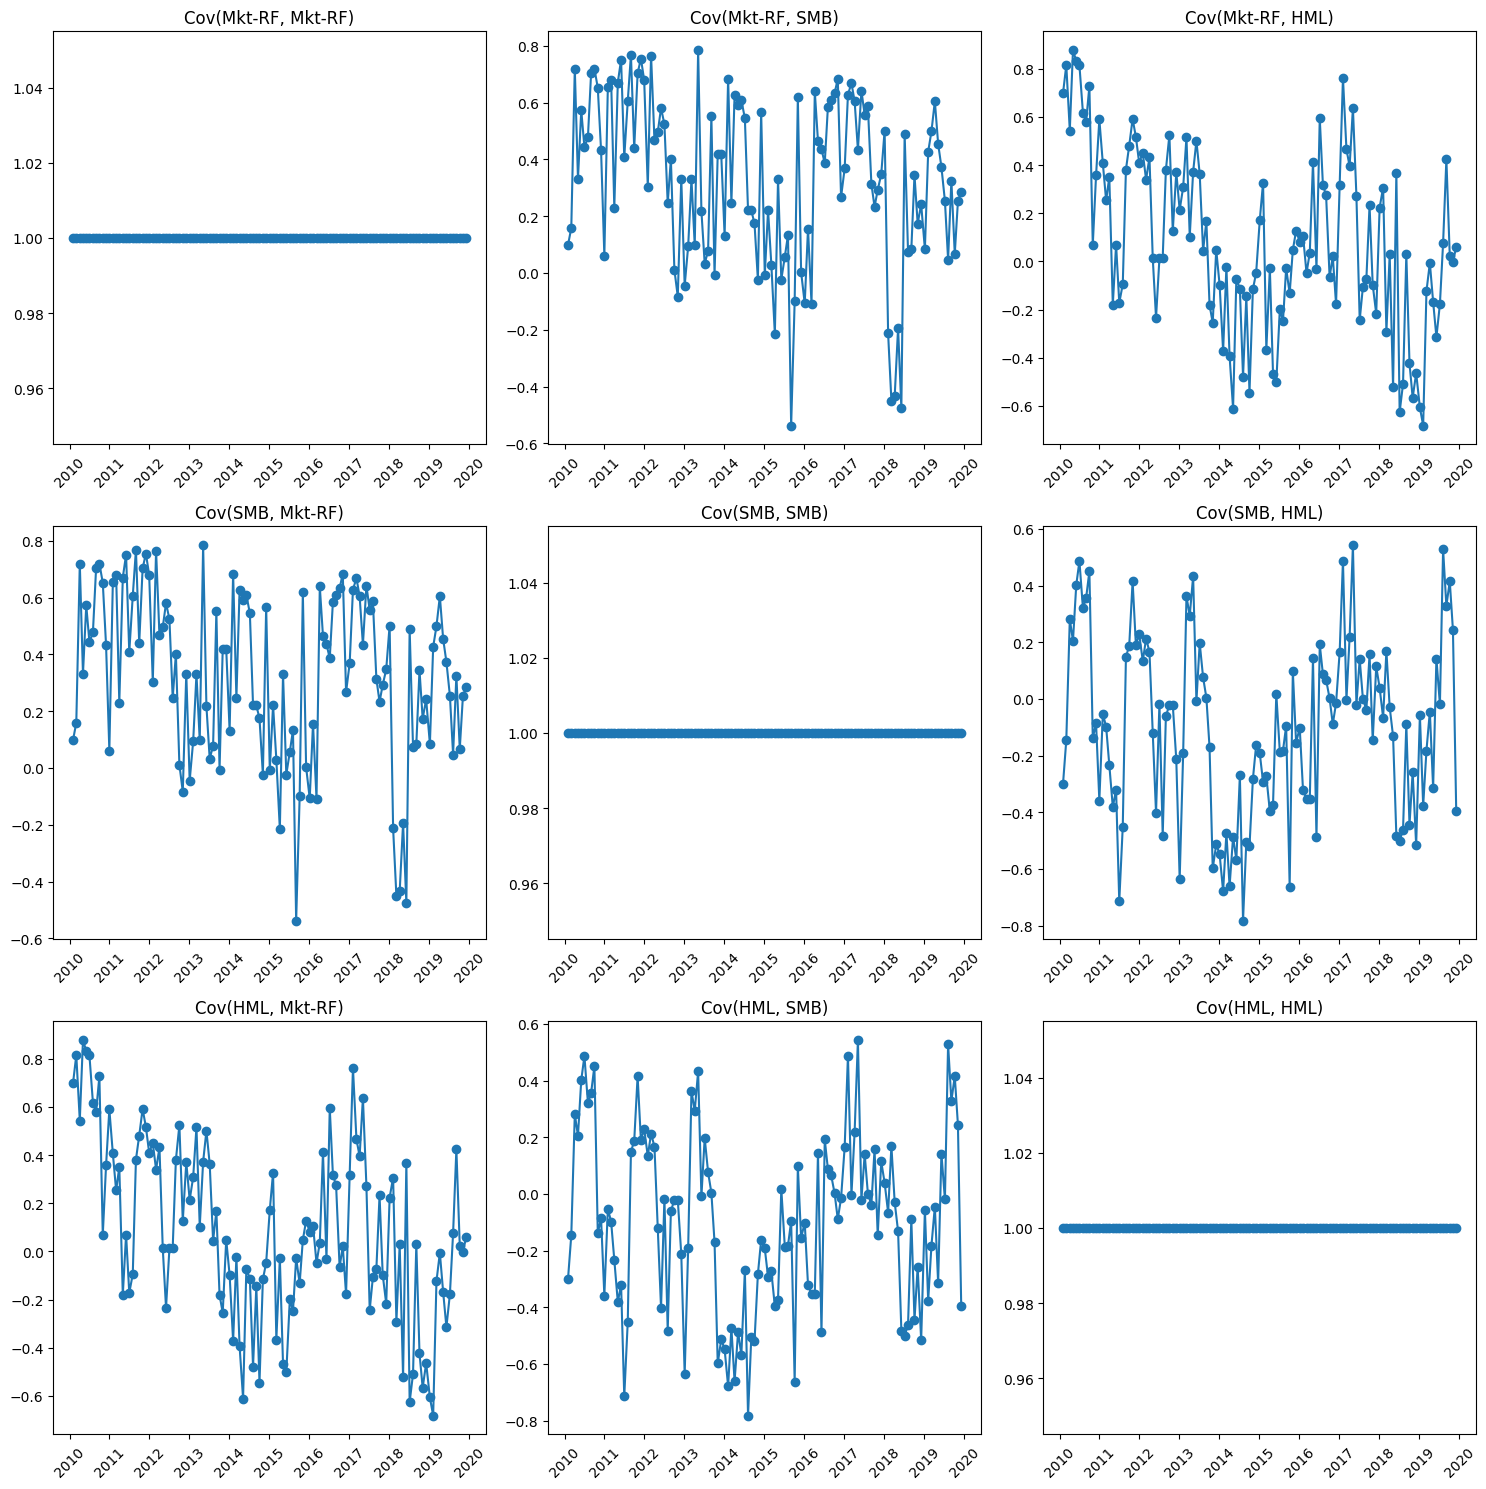

In [24]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt


def get_ff_factors(start_date, end_date):
    """
    Download Fama-French factors from Kenneth French's website
    """
    ff = pdr.DataReader(
        "F-F_Research_Data_Factors_daily", "famafrench", start=start_date, end=end_date
    )[0]
    ff = ff / 100.0
    return ff


def compute_nonoverlapping_covariances(ff_data, window=21):
    """
    Compute covariance matrices using non-overlapping windows
    window=21 corresponds to roughly one month of trading days
    """
    factors = ["Mkt-RF", "SMB", "HML"]

    # Calculate number of complete windows
    n_periods = len(ff_data) // window

    # Initialize array to store covariance matrices
    covs = np.zeros((n_periods, 3, 3))

    # Compute covariances for non-overlapping windows
    for i in range(n_periods):
        start_idx = i * window
        end_idx = (i + 1) * window
        window_data = ff_data[factors].iloc[start_idx:end_idx]
        covs[i] = window_data.corr().values

    return covs


def plot_covariance_evolution(covs, dates):
    """
    Plot the evolution of covariance matrix elements
    """
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    factors = ["Mkt-RF", "SMB", "HML"]

    for i in range(3):
        for j in range(3):
            axes[i, j].plot(dates, covs[:, i, j], "o-")  # Added points for clarity
            axes[i, j].set_title(f"Cov({factors[i]}, {factors[j]})")
            axes[i, j].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    return fig


def plot_acf(covs, max_lag=40):
    """
    Plot ACF for each element of the covariance matrices
    """
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    factors = ["Mkt-RF", "SMB", "HML"]

    for i in range(3):
        for j in range(3):
            # Get time series for this covariance element
            series = covs[:, i, j]

            # Compute ACF
            acf_values, confint, qstat, pvalues = acf(
                series, qstat=True, alpha=0.05, nlags=max_lag
            )

            # Plot ACF
            ax = axes[i, j]
            lags = np.arange(len(acf_values))
            ax.vlines(lags, [0], acf_values, color="blue")
            ax.axhline(y=0, color="black", linestyle="-")

            # Plot confidence bands
            ax.fill_between(
                lags,
                confint[:, 0] - acf_values,
                confint[:, 1] - acf_values,
                alpha=0.25,
                color="blue",
            )

            # Add labels
            ax.set_title(f"ACF of Cov({factors[i]}, {factors[j]})")
            ax.set_ylim([-1, 1])
            ax.set_xlabel("Lag")
            ax.set_ylabel("ACF")

            # Add text with Ljung-Box test p-value for first lag
            ax.text(
                0.05,
                0.95,
                f"Q-test p-value (lag 1): {pvalues[1]:.3f}",
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment="top",
            )

    plt.tight_layout()
    return fig


# Set the dates
historical_start = "1926-01-01"
historical_end = "2000-12-31"
modern_start = "2010-01-01"
modern_end = "2020-01-01"

# Window size (monthly)
window = 21

# Get historical data to compute null hypothesis mean
historical_ff = get_ff_factors(historical_start, historical_end)

# Compute historical covariances using non-overlapping windows
historical_covs = compute_nonoverlapping_covariances(historical_ff, window)

# Get modern data to test
modern_ff = get_ff_factors(modern_start, modern_end)

# Compute non-overlapping covariances for modern period
modern_covs = compute_nonoverlapping_covariances(modern_ff, window)


print(f"Number of independent observations: {len(modern_covs)}")

# Create dates for plotting (one per non-overlapping window)
dates = modern_ff.index[window - 1 :: window][: len(modern_covs)]
fig = plot_covariance_evolution(modern_covs, dates)

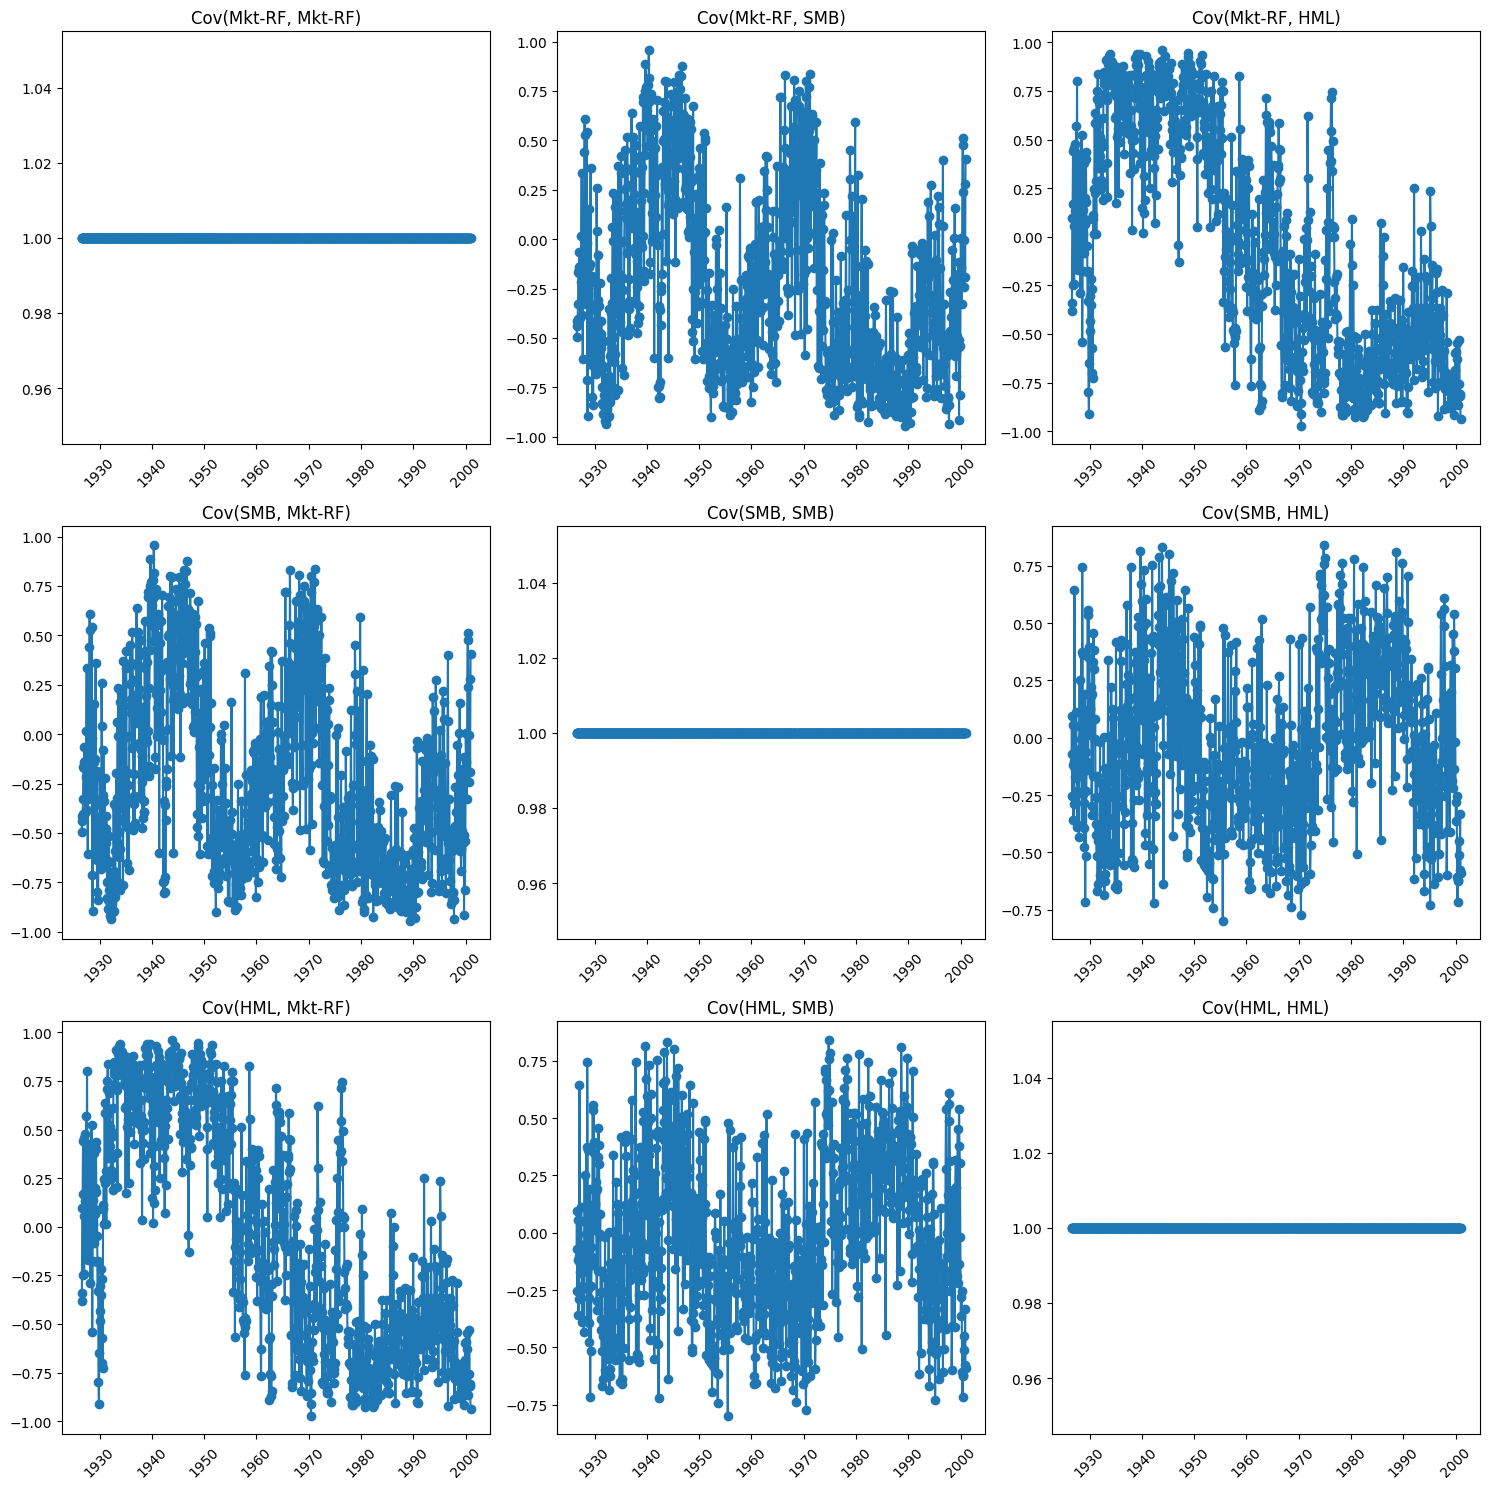

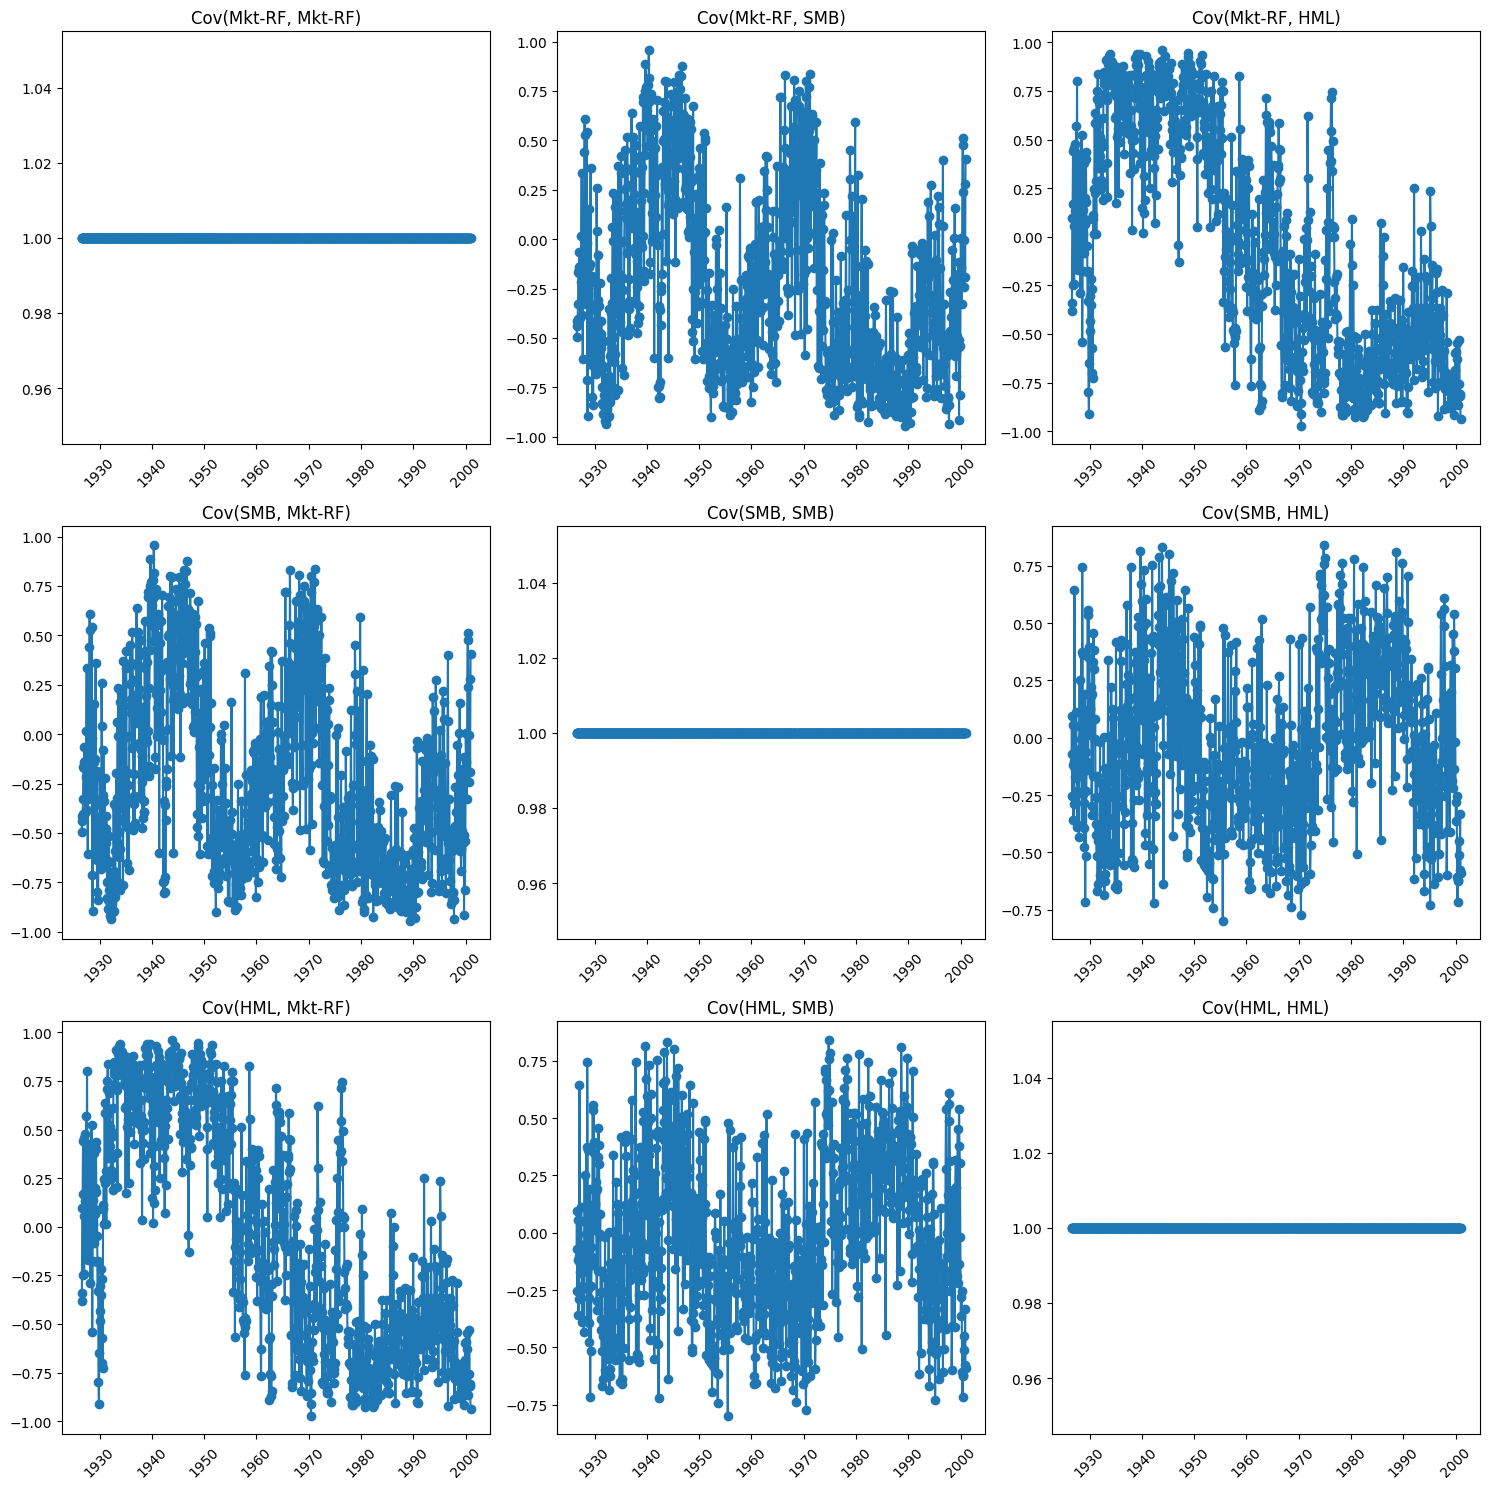

In [54]:
dates = historical_ff.index[window - 1 :: window][: len(historical_ff)]
plot_covariance_evolution(historical_covs, dates)

,SMB,HML
SMB,1.000000,-0.076563
HML,-0.076563,1.000000


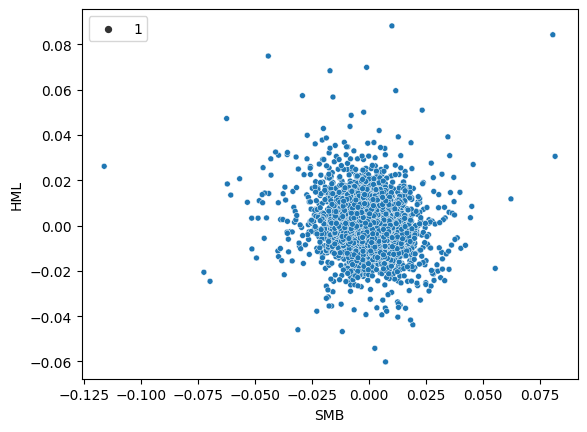

In [58]:
import seaborn as sns

sns.scatterplot(data=historical_ff, x="SMB", y="HML", size=1)
historical_ff[["SMB", "HML"]].corr()

array([[ 1.06116432e-04, -1.51358143e-05,  1.04666919e-05],
       [-1.51358143e-05,  3.43958123e-05, -2.58537554e-06],
       [ 1.04666919e-05, -2.58537554e-06,  3.31514584e-05]])

0.0

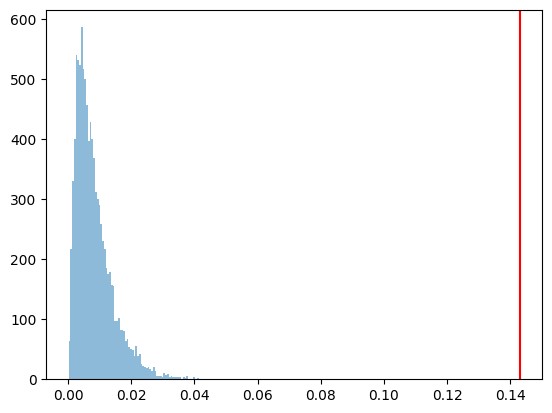

In [33]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from bures_wasserstein import BuresWassersteinN as BWN
from manifold import mirror_vecs


def mixture(key, x0, x1, p):
    num_dims = len(x0.shape) - 1
    shape = (x0.shape[0], *[1 for _ in range(num_dims)])
    z = jax.random.choice(
        key, jnp.array([0.0, 1.0]), shape=shape, p=jnp.array([p, 1 - p])
    )
    return z * x0 + (1.0 - z) * x1


num_bootstrap = 10_000


def proc_inner(M, x, mu_0, key):
    fm_key, key = jax.random.split(key, 2)
    x_mirrored = mirror_vecs(M, mu_0, x)

    mu_hat = M.frechet_mean(x, fm_key)
    t = M.dist(mu_hat, mu_0) ** 2

    def fun(it_key):
        z_key, fm_key = jax.random.split(it_key)
        x_b = mixture(z_key, x, x_mirrored, 1 / 2)
        mu_hat_b = M.frechet_mean(x_b, fm_key)
        return M.dist(mu_hat_b, mu_0) ** 2

    t_b = jax.vmap(fun)(jax.random.split(key, num_bootstrap))
    return t, t_b


# mean_h0 = BWN.frechet_mean(
#     jnp.array(historical_covs), jax.random.PRNGKey(np.random.randint(0, 2**32))
# )

mean_h0 = np.corrcoef(historical_ff[["Mkt-RF", "SMB", "HML"]].values, rowvar=False)

t, t_b = proc_inner(
    BWN,
    jnp.array(modern_covs),
    mean_h0,
    jax.random.PRNGKey(np.random.randint(0, 2**32)),
)

plt.axvline(t, color="red", label="T")
plt.hist(t_b, bins=100, alpha=0.5, label="T_b")
(t_b >= t).mean().item()

In [34]:
mean_h0

array([[ 1.        , -0.25053112,  0.17646834],
       [-0.25053112,  1.        , -0.0765631 ],
       [ 0.17646834, -0.0765631 ,  1.        ]])

In [50]:
BWN.frechet_mean(
    jnp.array(modern_covs), jax.random.PRNGKey(np.random.randint(0, 2**32))
)

Array([[ 0.9538178 ,  0.21017736,  0.0601638 ],
       [ 0.21017736,  0.9608541 , -0.07517481],
       [ 0.0601638 , -0.07517481,  0.9607297 ]], dtype=float32)